In [1]:
import numpy as np 
import nevis 

data = nevis.gb()

# area = np.load('res/area-with-sea.npy')
# label = np.load('res/label.npy')
maxima = np.load('../res/maxima.npy')
# path_sum = np.load('res/path_sum.npy')

We have to copy the code from the nevis library...

In [2]:

import matplotlib.colors
import matplotlib.figure
def plot(boundaries=None, labels=None, trajectory=None, points=None,
         scale_bar=True, big_grid=False, small_grid=False,
         zoom=1 / 27, headless=False, verbose=False, fig=None, ax=None):
    """
    Creates a plot of the 2D elevation data in ``heights``.

    By default, this method uses ``pyplot`` to create the figure, which can
    have the side-effect of instantiating a back-end for maptlotlib.
    Alternatively, the plot can be created in "headless" mode, by setting
    ``headless=True``.

    Arguments:

    ``boundaries``
        An optional tuple ``(xmin, xmax, ymin, ymax)`` defining the boundaries
        (in meters) of the plotted region.
    ``labels``
        An optional dictionary mapping string labels to points (tuples in
        meters or Coords objects) that will be plotted on the map (if within
        the boundaries).
    ``trajectory``
        An optional array of shape ``(n_points, 2)`` indicating the trajectory
        followed to get to Ben Nevis (points specified in meters).
    ``points``
        An optional array of shape ``(n_points, 2)`` indicating points on the
        map (points specified in meters).
    ``scale_bar``
        Set to ``False`` to disable the scale bar.
    ``big_grid``
        Show the 2-letter grid squares (100km by 100km).
    ``small_grid``
        Show the 2-letter 2-number grid squares (10km by 10km)
    ``zoom``
        Adjust plot size by interpolating (``zoom > 1``) or downsampling (
        ``zoom < 1``).

        To downsample by e.g. a factor 10, set ``zoom = 1 / 10``. To
        interpolate and show e.g. 3x3 pixels per data point, set ``zoom = 3``.
        Interpolation is performed using matplotlib's "bilinear interpolation".

        The default value is ``1 / 27``, which creates a reasonably sized plot
        for the full GB data set.
    ``headless``
        Set to ``True`` to create the figure without using pyplot.
    ``verbose``
        Set to ``True`` to print updates to ``stdout`` while plotting.

    Returns a tuple ``(fig, ax, heights, g)`` where ``fig`` is the created
    figure, ``ax`` is the axes the image is plotted on, and ``heights`` is the
    (possibly downsampled) numpy array. The final entry ``g`` is a function
    that converts coordinates in meters to coordinates on the map axes.
    """
    # Current array shape
    heights = nevis.gb()
    ny, nx = heights.shape

    # Get extreme points (before any downsampling!)
    vmin = np.min(heights)
    vmax = np.max(heights)
    if verbose:
        print(f'Lowest point: {vmin}')
        print(f'Highest point: {vmax}')

    # Calculate downsampling using zoom
    if zoom > 1:
        downsampling = 1
    else:
        downsampling = int(round(1 / zoom))
        zoom = 1

    # Downsample (27 gives me a map that fits on my screen at 100% zoom).
    if downsampling > 1:
        if verbose:
            print(f'Downsampling with factor {downsampling}')
        heights = heights[::downsampling, ::downsampling]
        ny, nx = heights.shape

    # Select region to plot, and create meters2indices method
    d_org = d_new = np.array(nevis.dimensions())    # In meters
    offset = np.array([0, 0])                       # In meters
    if boundaries is not None:
        xlo, xhi, ylo, yhi = [float(x) for x in boundaries]

        # Select appropriate part of array
        xlo = max(0, int(xlo / d_org[0] * nx))
        ylo = max(0, int(ylo / d_org[1] * ny))
        xhi = min(nx, int(np.ceil(xhi / d_org[0] * nx)))
        yhi = min(ny, int(np.ceil(yhi / d_org[1] * ny)))

        heights = heights[ylo:yhi, xlo:xhi]

        # Adjust array size
        ny, nx = heights.shape

        # Set new dimensions and origin (bottom left)
        r = nevis.spacing() * downsampling
        d_new = np.array([nx * r, ny * r])
        offset = np.array([xlo * r, ylo * r])

    def meters2indices(x, y):
        """ Convert meters to array indices (which equal image coordinates) """
        x = (x - offset[0]) / d_new[0] * nx
        y = (y - offset[1]) / d_new[1] * ny
        try:
            x, y = int(x), int(y)
        except TypeError:
            x, y = x.astype(int), y.astype(int)
        return x, y

    # Plot
    if verbose:
        print('Plotting...')

    # Create colormap
    # f = absolute height, g = relative to vmax (and zero)
    f = lambda x: (x - vmin) / (vmax - vmin)
    # g = lambda x: f(x * vmax)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'soundofmusic', [
            (0, '#4872d3'),             # Deep sea blue
            (f(-0.1), '#68b2e3'),       # Shallow sea blue
            (f(0.0), '#0f561e'),        # Dark green
            (f(10), '#1a8b33'),         # Nicer green
            (f(100), '#11aa15'),        # Glorious green
            (f(300), '#e8e374'),        # Yellow at ~1000ft
            (f(610), '#8a4121'),        # Brownish at ~2000ft
            (f(915), '#999999'),        # Grey at ~3000ft
            (1, 'white'),
        ], N=1024)
    #import matplotlib.cm
    #cmap = matplotlib.cm.get_cmap('inferno')

    # Work out figure dimensions
    # Note: Matplotlib defaults to 100 dots per inch and 72 points per inch for
    # font sizes and line widths. This means that increasing the dpi leads to
    # more pixels per inch, but also to much bigger letters and thicker lines,
    # as it assumes the physical size should stay the same when printed!
    dpi = 100
    fw = nx * zoom / dpi
    fh = ny * zoom / dpi
    if verbose:
        print(f'Figure dimensions: {fw}" by {fh}" at {dpi} dpi')
        print(f'Should result in {int(fw * dpi)} by {int(fh * dpi)} pixels.')


    if ax is None:
        # Create figure
        if headless:
            fig = matplotlib.figure.Figure(figsize=(fw, fh), dpi=dpi)
        else:
            import matplotlib.pyplot as plt
            fig = plt.figure(figsize=(fw, fh), dpi=dpi)
        fig.subplots_adjust(0, 0, 1, 1)

        # Add axes
        ax = fig.add_subplot(1, 1, 1)

    ax.set_axis_off()
    ax.imshow(
        heights,
        origin='lower',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        interpolation='bilinear' if zoom > 1 else 'none',
    )
    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)

    # Add grid
    if small_grid:
        for sq, x0, y0 in nevis.squares():
            for j in range(10):
                for i in range(10):
                    x, y = x0 + j * 10000, y0 + i * 10000
                    if y == 0 and x > 0:
                        q, r = meters2indices(x, y)
                        if q > 2 and q < nx - 2:
                            ax.axvline(q, color='w', lw=0.5)
                    elif x == 0 and y > 0:
                        q, r = meters2indices(x, y)
                        if r > 2 and r < ny - 2:
                            ax.axhline(r, color='w', lw=0.5)
                    q, r = meters2indices(x + 5000, y + 5000)
                    if q > 10 and q < nx - 10 and r > 10 and r < ny - 10:
                        ax.text(q, r, sq + str(j) + str(i), color='w',
                                ha='center', va='center', fontsize=10)
    elif big_grid:
        for sq, x, y in nevis.squares():
            if y == 0 and x > 0:
                q, r = meters2indices(x, y)
                if q > 0 and q < nx:
                    ax.axvline(q, color='w', lw=0.5)
            elif x == 0 and y > 0:
                q, r = meters2indices(x, y)
                if r > 0 and r < ny:
                    ax.axhline(r, color='w', lw=0.5)
            q, r = meters2indices(x + 50000, y + 50000)
            if q > 20 and q < nx - 20 and r > 10 and r < ny - 10:
                ax.text(q, r, sq, color='w',
                        ha='center', va='center', fontsize=14)

    # Add scale bar
    if scale_bar:
        # Guess a good size
        x = d_new[0] / 5
        if x > 250e3:
            x = int(round(x / 250e3) * 250e3)
        elif x > 90e3:
            x = int(round(x / 100e3) * 100e3)
        elif x > 9e3:
            x = int(round(x / 10e3) * 10e3)
        elif x > 4.5e3:
            x = int(round(x / 5e3) * 5e3)
        elif x > 1e3:
            x = int(round(x / 1e3) * 1e3)
        else:
            x = int(round(x / 100) * 100)
        t = f'{x}m' if x < 1000 else f'{x // 1000}km'
        x = x / d_new[0] * nx
        y = 0.05 * ny
        dy = 0.015 * ny
        x0, x1 = 0.5 * x, 1.5 * x
        ax.plot([x0, x1], [y, y], 'white', lw=1)
        ax.plot([x0, x0], [y - dy, y + dy], 'white', lw=1)
        ax.plot([x1, x1], [y - dy, y + dy], 'white', lw=1)
        ax.text(0.5 * (x0 + x1), y + 0.5 * dy, t, color='white',
                horizontalalignment='center')

    # Show requested points
    if points is not None:
        x, y = meters2indices(points[:, 0], points[:, 1])
        ax.plot(
            x, y, 'x', color='#0000ff',
            markeredgewidth=1, markersize=4, alpha=0.3)

    # Show trajectory
    if trajectory is not None:
        x, y = meters2indices(trajectory[:, 0], trajectory[:, 1])
        ax.plot(
            x, y, 'o-', color='#000000',
            lw=0.5, markeredgewidth=0.5, markersize=4)

    # Add labelled points
    if labels:
        n_plotted = 0
        kwargs = {'fillstyle': 'none', 'markersize': 12}
        for label, p in labels.items():
            if isinstance(p, nevis.Coords):
                p = p.grid
            x, y = meters2indices(*p)
            if x > 0 and x < nx and y > 0 and y < ny:
                n_plotted += 1
                ax.plot(x, y, 'wo', markeredgewidth=3, **kwargs)
                ax.plot(x, y, 'o', markeredgewidth=2, label=label, **kwargs)

        if n_plotted:
            ax.legend(
                loc='upper left',
                framealpha=1,
                handlelength=1.5,
                handletextpad=0.9,
            )

    return fig, ax, heights, meters2indices

In [3]:
maxima_heights = []

for x, y in maxima:
    maxima_heights.append(data[x, y])

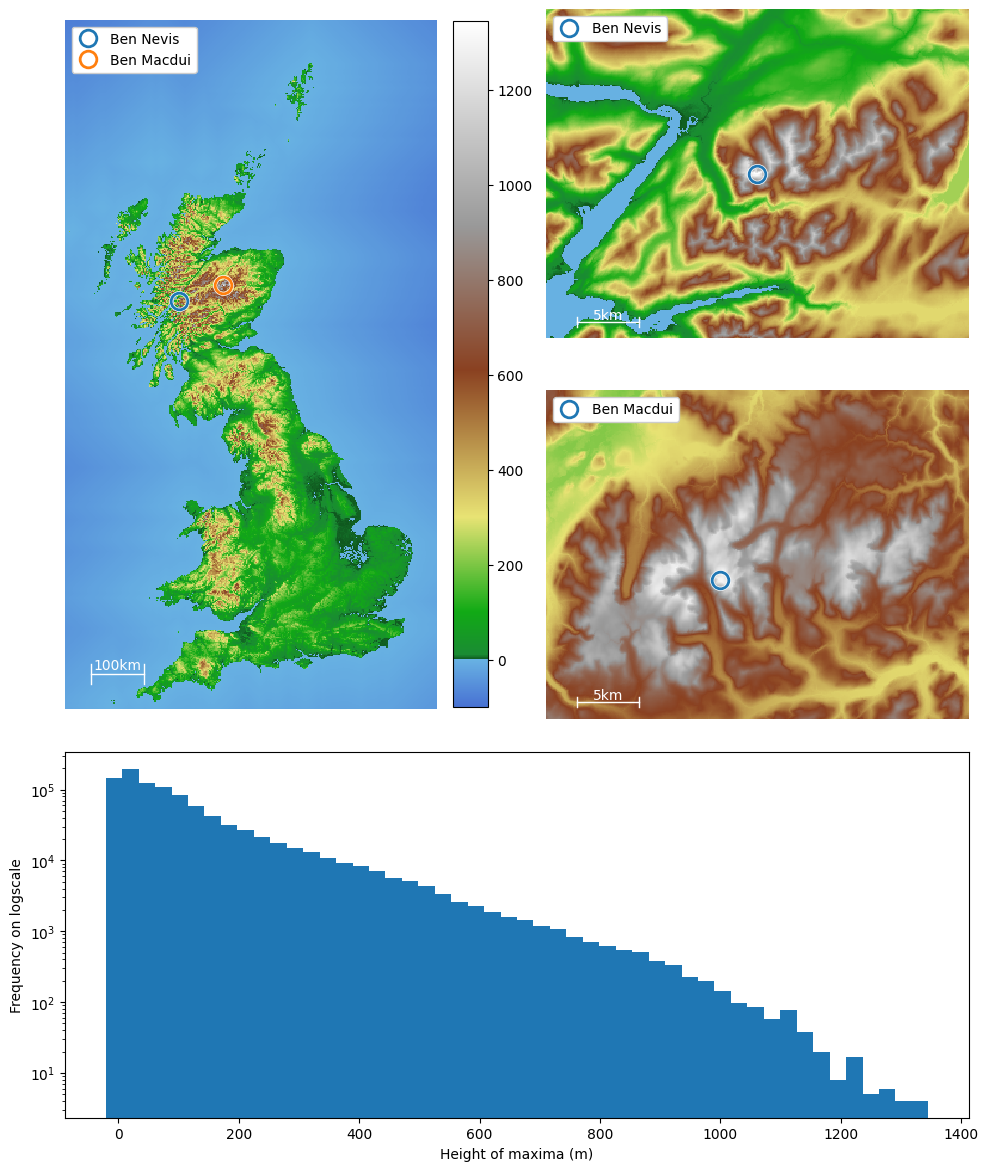

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(10, 12))

# Define the GridSpec layout
gs = gridspec.GridSpec(3, 2)  # 3 rows, 2 columns

# Create subplots
ax1 = fig.add_subplot(gs[0:2, 0])  # Span first two rows of the first column
ax2 = fig.add_subplot(gs[0, 1])    # First row, second column
ax3 = fig.add_subplot(gs[1, 1])    # Second row, second column
ax4 = fig.add_subplot(gs[2, :])    # Span the third row across both columns


ben_x, ben_y = nevis.ben().grid
mac_h, mac_bdr = nevis.macdui()
mac_hg = mac_h.coords.grid
labels = {
    'Ben Nevis': [ben_x, ben_y],
    'Ben Macdui': mac_hg,
}
plot(ax=ax1, 
     labels=labels,
     zoom=1/45)
b = 8e3
plot(ax=ax2,         
     boundaries=[ben_x - b * 2.125, 
                 ben_x + b * 2.125, 
                 ben_y - b * 1.65, 
                 ben_y + b * 1.65],
     zoom=1/1.5,
     labels=labels,)
plot(ax=ax3,         
     boundaries=mac_bdr,
     zoom=1/1.5,
     labels=labels,)

heights = nevis.gb()
vmin = np.min(heights)
vmax = np.max(heights)
def f(x): return (x - vmin) / (vmax - vmin)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'soundofmusic', [
        (0, '#4872d3'),             # Deep sea blue
        (f(-0.1), '#68b2e3'),       # Shallow sea blue
        (f(0.0), '#0f561e'),        # Dark green
        (f(10), '#1a8b33'),         # Nicer green
        (f(100), '#11aa15'),        # Glorious green
        (f(300), '#e8e374'),        # Yellow at ~1000ft
        (f(610), '#8a4121'),        # Brownish at ~2000ft
        (f(915), '#999999'),        # Grey at ~3000ft
        (1, 'white'),
        ], N=1024)
sm = plt.cm.ScalarMappable(
        cmap=cmap, norm=matplotlib.colors.Normalize(vmin, vmax))
sm.set_array([])
fig.colorbar(sm, ax=ax1, fraction=0.081, pad=0.04)

ax4.hist(maxima_heights, log=True, bins=50)
# ax4.title('Histogram of the heights of local maxima')
ax4.set_xlabel('Height of maxima (m)')
ax4.set_ylabel('Frequency on logscale')

# Adjust layout if necessary
plt.tight_layout()

# Show the figure
plt.show()